# Task B - Step 2: Named Entity Recognition (NER) for LLM Products
## Revised Version: Parent Brand Mapping

## Overview
Identify which LLM products are mentioned in each Reddit post, mapped to parent brands.

## Parent Brand Groups:
- **ChatGPT**: GPT-4, GPT-4o, o1, o3, ChatGPT
- **Claude**: Claude 3.5 Sonnet, Claude 3 Opus, Claude 3 Sonnet, Claude 3 Haiku, Anthropic
- **Gemini**: Gemini 1.5 Pro, Gemini Advanced, Google AI
- **DeepSeek**: DeepSeek, DeepSeek-R1
- **Grok**: Grok, Grok-2, xAI
- **Meta**: Meta AI, LLaMA

In [2]:
## Import Libraries
import pandas as pd
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully")

 Libraries imported successfully


## Step 1: Load Sentiment-Labeled Data

In [4]:
# Load data with sentiment from Step 1
df = pd.read_csv("reddit_llms_with_sentiment.csv")

# Ensure we have the text column
if 'text' not in df.columns:
    df['text'] = (df['title'].fillna('') + ' ' + df['selftext'].fillna('')).str.strip()

print(f" Loaded {len(df)} posts with sentiment labels")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSubreddits in dataset:")
for sub in df['subreddit'].unique():
    count = (df['subreddit'] == sub).sum()
    print(f"  - {sub}: {count} posts")

print(f"\nSample data:")
df[['id', 'subreddit', 'sentiment_label']].head()

 Loaded 2440 posts with sentiment labels

Columns: ['id', 'title', 'selftext', 'score', 'num_comments', 'url', 'created_utc', 'subreddit', 'has_image', 'embedding_text', 'embedding_image', 'embedding_combined', 'text', 'sentiment_label', 'sentiment_score']

Subreddits in dataset:
  - ChatGPT: 500 posts
  - ClaudeAI: 500 posts
  - GeminiAI: 500 posts
  - GrokAI: 440 posts
  - DeepSeek: 500 posts

Sample data:


,id,subreddit,sentiment_label
0,1ogadtk,ChatGPT,neutral
1,1ogaaic,ChatGPT,negative
2,1oga6th,ChatGPT,neutral
3,1og9qdp,ChatGPT,negative
4,1og9o5h,ChatGPT,neutral


## Step 2: Define Parent LLM Mapping

Map all LLM variants to their parent brand

In [7]:
# Parent LLM Mapping - Group ALL versions under parent brand
PARENT_LLM_MAPPING = {
    # OpenAI family → ChatGPT
    "ChatGPT": "ChatGPT",
    "GPT-4": "ChatGPT",
    "GPT-4o": "ChatGPT",
    "o1": "ChatGPT",
    "o3": "ChatGPT",
    
    # Anthropic family → Claude
    "Claude": "Claude",
    "Claude 3.5 Sonnet": "Claude",
    "Claude 3 Opus": "Claude",
    "Claude 3 Sonnet": "Claude",
    "Claude 3 Haiku": "Claude",
    "Anthropic": "Claude",
    
    # Google family → Gemini
    "Gemini": "Gemini",
    "Gemini 1.5 Pro": "Gemini",
    "Gemini 1.5 Flash": "Gemini",
    "Gemini Advanced": "Gemini",
    "Google": "Gemini",  # Google AI → Gemini (as requested)
    
    # xAI family → Grok
    "Grok": "Grok",
    "Grok-2": "Grok",
    "xAI": "Grok",
    
    # DeepSeek family → DeepSeek
    "DeepSeek": "DeepSeek",
    "DeepSeek-R1": "DeepSeek",
    
    # Meta family → Meta
    "Meta": "Meta",
    "LLaMA": "Meta"
}

def map_to_parent_llm(llm_name):
    """Map any LLM variant to its parent brand"""
    return PARENT_LLM_MAPPING.get(llm_name, llm_name)

# Subreddit to Parent LLM Mapping
SUBREDDIT_TO_PARENT_LLM = {
    'ChatGPT': 'ChatGPT',
    'ClaudeAI': 'Claude',
    'GeminiAI': 'Gemini',
    'DeepSeek': 'DeepSeek',
    'GrokAI': 'Grok'
}

print(f" Parent LLM mapping defined")
print(f"\n  Parent brands tracked:")
unique_parents = sorted(set(PARENT_LLM_MAPPING.values()))
for i, parent in enumerate(unique_parents, 1):
    print(f"    {i}. {parent}")

print(f"\n  Example mappings:")
print(f"    - 'GPT-4o' → '{map_to_parent_llm('GPT-4o')}'")
print(f"    - 'Claude 3.5 Sonnet' → '{map_to_parent_llm('Claude 3.5 Sonnet')}'")
print(f"    - 'Gemini 1.5 Pro' → '{map_to_parent_llm('Gemini 1.5 Pro')}'")
print(f"    - 'Google' → '{map_to_parent_llm('Google')}'")
print(f"    - 'DeepSeek-R1' → '{map_to_parent_llm('DeepSeek-R1')}'")

 Parent LLM mapping defined

  Parent brands tracked:
    1. ChatGPT
    2. Claude
    3. DeepSeek
    4. Gemini
    5. Grok
    6. Meta

  Example mappings:
    - 'GPT-4o' → 'ChatGPT'
    - 'Claude 3.5 Sonnet' → 'Claude'
    - 'Gemini 1.5 Pro' → 'Gemini'
    - 'Google' → 'Gemini'
    - 'DeepSeek-R1' → 'DeepSeek'


## Step 3: Define LLM Detection Patterns

Regex patterns to detect LLM mentions in text (before mapping to parent)

In [9]:
# LLM Detection Patterns (comprehensive list of variants)
LLM_ONTOLOGY = {
    # OpenAI Products
    "ChatGPT": [
        r"\bchatgpt\b", r"\bchat\s*gpt\b", r"\bgpt\s*chat\b", r"\bchat-gpt\b"
    ],
    "GPT-4": [
        r"\bgpt\s*-?\s*4(?!\d|o)\b", r"\bgpt4(?!\d|o)\b"
    ],
    "GPT-4o": [
        r"\bgpt\s*-?\s*4o\b", r"\bgpt4o\b"
    ],
    "o1": [
        r"\bo1(?:-preview|-mini)?\b", r"\bopen\s*ai\s*o1\b"
    ],
    "o3": [
        r"\bo3(?:-mini)?\b"
    ],
    
    # Anthropic Products
    "Claude": [
        r"\bclaude(?!\s*\d)\b"
    ],
    "Claude 3.5 Sonnet": [
        r"\bclaude\s*3\.?5\s*sonnet\b", r"\bclaude\s*sonnet\s*3\.?5\b"
    ],
    "Claude 3 Opus": [
        r"\bclaude\s*3\s*opus\b", r"\bclaude\s*opus\s*3\b"
    ],
    "Claude 3 Sonnet": [
        r"\bclaude\s*3\s*sonnet\b", r"\bclaude\s*sonnet\s*3\b"
    ],
    "Claude 3 Haiku": [
        r"\bclaude\s*3\s*haiku\b", r"\bclaude\s*haiku\s*3\b"
    ],
    
    # Google Products
    "Gemini": [
        r"\bgemini(?!\s*\d)\b"
    ],
    "Gemini 1.5 Pro": [
        r"\bgemini\s*1\.?5\s*pro\b", r"\bgemini\s*pro\s*1\.?5\b"
    ],
    "Gemini 1.5 Flash": [
        r"\bgemini\s*1\.?5\s*flash\b"
    ],
    "Gemini Advanced": [
        r"\bgemini\s*advanced\b"
    ],
    "Google": [
        r"\bgoogle\s*ai\b", r"\bgoogle\s*bard\b"
    ],
    
    # xAI Products
    "Grok": [
        r"\bgrok(?!-?\d)\b"
    ],
    "Grok-2": [
        r"\bgrok\s*-?\s*2\b"
    ],
    "xAI": [
        r"\bxai\b", r"\bx\.ai\b"
    ],
    
    # DeepSeek Products
    "DeepSeek": [
        r"\bdeepseek(?!-?r?1)\b"
    ],
    "DeepSeek-R1": [
        r"\bdeepseek\s*-?\s*r\s*-?\s*1\b", r"\bdeepseek\s*r1\b"
    ],
    
    # Other Products
    "Meta": [
        r"\bmeta\s*ai\b"
    ],
    "LLaMA": [
        r"\bllama\b"
    ],
    "Anthropic": [
        r"\banthropic\b"
    ]
}

# Compile regex patterns for efficiency
compiled_patterns = {}
for llm_name, patterns in LLM_ONTOLOGY.items():
    compiled_patterns[llm_name] = [re.compile(p, re.IGNORECASE) for p in patterns]

print(f" Defined detection patterns for {len(LLM_ONTOLOGY)} LLM variants")

 Defined detection patterns for 23 LLM variants


## Step 4: Create LLM Extraction Function

In [12]:
def extract_llm_mentions(text):
    """
    Extract LLM mentions from text
    Returns list of detected LLMs (before parent mapping)
    """
    if pd.isna(text) or text == '':
        return []
    
    mentions = []
    text_lower = text.lower()
    
    # Search for each LLM using compiled regex patterns
    for llm_name, patterns in compiled_patterns.items():
        for pattern in patterns:
            if pattern.search(text_lower):
                mentions.append({
                    'llm_name': llm_name,
                    'position': pattern.search(text_lower).start()
                })
                break  # Found this LLM, move to next
    
    # Sort by position (first mention first)
    mentions.sort(key=lambda x: x['position'])
    
    return mentions

# Test the extraction function
test_cases = [
    "I tried ChatGPT and it's better than Claude 3.5 Sonnet",
    "GPT-4o vs Gemini 1.5 Pro comparison",
    "How do I improve my prompts?",
    "DeepSeek-R1 is amazing! Better than o3",
    "Google AI (now Gemini) works well"
]

print(" LLM extraction function created\n")
print("Testing extraction:\n")
for i, test_text in enumerate(test_cases, 1):
    mentions = extract_llm_mentions(test_text)
    if mentions:
        detected = [m['llm_name'] for m in mentions]
        parents = [map_to_parent_llm(m['llm_name']) for m in mentions]
        print(f"Test {i}: \"{test_text}\"")
        print(f"  Detected: {detected}")
        print(f"  Parents: {parents}")
        print(f"  Primary: {parents[0] if parents else 'None'}\n")
    else:
        print(f"Test {i}: \"{test_text}\"")
        print(f"  Detected: None\n")

 LLM extraction function created

Testing extraction:

Test 1: "I tried ChatGPT and it's better than Claude 3.5 Sonnet"
  Detected: ['ChatGPT', 'Claude 3.5 Sonnet']
  Parents: ['ChatGPT', 'Claude']
  Primary: ChatGPT

Test 2: "GPT-4o vs Gemini 1.5 Pro comparison"
  Detected: ['GPT-4o', 'Gemini 1.5 Pro']
  Parents: ['ChatGPT', 'Gemini']
  Primary: ChatGPT

Test 3: "How do I improve my prompts?"
  Detected: None

Test 4: "DeepSeek-R1 is amazing! Better than o3"
  Detected: ['DeepSeek-R1', 'o3']
  Parents: ['DeepSeek', 'ChatGPT']
  Primary: DeepSeek

Test 5: "Google AI (now Gemini) works well"
  Detected: ['Google', 'Gemini']
  Parents: ['Gemini', 'Gemini']
  Primary: Gemini



## Step 5: Extract Primary LLM from Each Post

**Logic**: 
- Extract LLM mentions from text
- Take FIRST (primary) mention
- Map to parent brand
- Result: ONE LLM per post

In [15]:
print("="*70)
print("PHASE 1: EXTRACTING PRIMARY LLM FROM TEXT")
print("="*70)

print(f"\nProcessing {len(df)} posts...")
print("Logic: Extract LLMs from text → Take FIRST mention → Map to parent brand\n")

# Store one LLM per post
post_llm_mapping = {}

for idx, row in df.iterrows():
    post_id = row.get('id')
    text = str(row.get('text', ''))
    
    # Extract LLM mentions from text
    mentions = extract_llm_mentions(text)
    
    if mentions:
        # Post has explicit mention(s) - take FIRST one
        first_mention = mentions[0]['llm_name']
        parent_llm = map_to_parent_llm(first_mention)
        
        post_llm_mapping[post_id] = {
            'llm_parent': parent_llm,
            'llm_detected': first_mention,
            'mention_source': 'explicit',
            'num_detected': len(mentions)  # Track how many were found
        }
    else:
        # No explicit mention - will add from subreddit later
        post_llm_mapping[post_id] = None
    
    # Progress indicator
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{len(df)} posts...")

print(f"\n Completed text extraction for all posts")

# Statistics
posts_with_explicit = sum(1 for v in post_llm_mapping.values() if v is not None)
posts_without_explicit = len(post_llm_mapping) - posts_with_explicit

print(f"\n PHASE 1 RESULTS:")
print(f"   Total posts: {len(df)}")
print(f"   Posts WITH explicit LLM in text: {posts_with_explicit} ({posts_with_explicit/len(df)*100:.1f}%)")
print(f"   Posts WITHOUT explicit mention: {posts_without_explicit} ({posts_without_explicit/len(df)*100:.1f}%)")

# Show parent brand distribution so far
explicit_parents = [v['llm_parent'] for v in post_llm_mapping.values() if v is not None]
parent_counts = Counter(explicit_parents)
print(f"\n  Parent LLM distribution (explicit only):")
for parent, count in parent_counts.most_common():
    print(f"    {parent:15s}: {count:4d} posts")

PHASE 1: EXTRACTING PRIMARY LLM FROM TEXT

Processing 2440 posts...
Logic: Extract LLMs from text → Take FIRST mention → Map to parent brand

  Processed 500/2440 posts...
  Processed 1000/2440 posts...
  Processed 1500/2440 posts...
  Processed 2000/2440 posts...

 Completed text extraction for all posts

 PHASE 1 RESULTS:
   Total posts: 2440
   Posts WITH explicit LLM in text: 1619 (66.4%)
   Posts WITHOUT explicit mention: 821 (33.6%)

  Parent LLM distribution (explicit only):
    Claude         :  447 posts
    DeepSeek       :  315 posts
    ChatGPT        :  309 posts
    Gemini         :  283 posts
    Grok           :  264 posts
    Meta           :    1 posts


## Step 6: Add Implicit LLM from Subreddit

For posts WITHOUT explicit mentions, infer parent LLM from subreddit

In [17]:
print("\n" + "="*70)
print("PHASE 2: ADDING LLM FROM SUBREDDIT (For posts without explicit mentions)")
print("="*70)

print("\n Logic: Posts without explicit mention → Use subreddit → Map to parent")
print(f"\nSubreddit mappings:")
for sub, parent in SUBREDDIT_TO_PARENT_LLM.items():
    print(f"  r/{sub:15s} → {parent}")

# Add implicit LLMs from subreddit
implicit_added = 0

for post_id, llm_data in post_llm_mapping.items():
    if llm_data is None:  # No explicit mention
        # Find the post's subreddit
        post_row = df[df['id'] == post_id].iloc[0]
        subreddit = post_row['subreddit']
        
        if subreddit in SUBREDDIT_TO_PARENT_LLM:
            parent_llm = SUBREDDIT_TO_PARENT_LLM[subreddit]
            post_llm_mapping[post_id] = {
                'llm_parent': parent_llm,
                'llm_detected': f'[Implicit from r/{subreddit}]',
                'mention_source': 'implicit',
                'num_detected': 0
            }
            implicit_added += 1

print(f"\n Added {implicit_added} implicit LLM associations from subreddit")

# Final statistics
posts_explicit = sum(1 for v in post_llm_mapping.values() if v and v['mention_source'] == 'explicit')
posts_implicit = sum(1 for v in post_llm_mapping.values() if v and v['mention_source'] == 'implicit')
posts_missing = sum(1 for v in post_llm_mapping.values() if v is None)

print(f"\n PHASE 2 RESULTS:")
print(f"   Posts with explicit LLM: {posts_explicit}")
print(f"   Posts with implicit LLM: {posts_implicit}")
print(f"   Posts still missing LLM: {posts_missing}")
print(f"   Total coverage: {(posts_explicit + posts_implicit) / len(df) * 100:.1f}%")

if posts_missing > 0:
    print(f"\n  Warning: {posts_missing} posts still without LLM")
    missing_posts = [k for k, v in post_llm_mapping.items() if v is None]
    print(f"   Missing post IDs: {missing_posts[:10]}...")


PHASE 2: ADDING LLM FROM SUBREDDIT (For posts without explicit mentions)

 Logic: Posts without explicit mention → Use subreddit → Map to parent

Subreddit mappings:
  r/ChatGPT         → ChatGPT
  r/ClaudeAI        → Claude
  r/GeminiAI        → Gemini
  r/DeepSeek        → DeepSeek
  r/GrokAI          → Grok

 Added 0 implicit LLM associations from subreddit

 PHASE 2 RESULTS:
   Posts with explicit LLM: 1619
   Posts with implicit LLM: 821
   Posts still missing LLM: 0
   Total coverage: 100.0%


## Step 7: Create Entity DataFrame (ONE row per post)

Final result: 2,440 rows with parent LLM brands

In [19]:
print("\n" + "="*70)
print("CREATING FINAL ENTITY DATAFRAME")
print("="*70)

print("\n Key point: ONE row per post (not multiple)")

# Create entity records - ONE per post
entity_rows = []

for post_id, llm_data in post_llm_mapping.items():
    if llm_data:  # Has LLM assignment
        # Get post data
        post_row = df[df['id'] == post_id].iloc[0]
        
        entity_rows.append({
            'id': post_id,
            'subreddit': post_row['subreddit'],
            'sentiment_label': post_row['sentiment_label'],
            'sentiment_score': post_row['sentiment_score'],
            'llm_parent': llm_data['llm_parent'],
            'llm_detected': llm_data['llm_detected'],
            'mention_source': llm_data['mention_source']
        })

# Create DataFrame
entities_df = pd.DataFrame(entity_rows)

print(f"\n Entity DataFrame created")
print(f"\n  Expected rows: {len(df)}")
print(f"  Actual rows: {len(entities_df)}")
print(f"  Match: {' PERFECT' if len(entities_df) == len(df) else f' Missing {len(df) - len(entities_df)} posts'}")

print(f"\n Parent LLM Distribution:")
parent_dist = entities_df['llm_parent'].value_counts()
for parent, count in parent_dist.items():
    pct = count / len(entities_df) * 100
    print(f"   {parent:15s}: {count:4d} posts ({pct:5.1f}%)")

print(f"\n Mention Source Distribution:")
source_dist = entities_df['mention_source'].value_counts()
for source, count in source_dist.items():
    pct = count / len(entities_df) * 100
    print(f"   {source:10s}: {count:4d} posts ({pct:5.1f}%)")

print(f"\n Sample entity data:")
display_cols = ['id', 'subreddit', 'llm_parent', 'mention_source', 'sentiment_label']
print(entities_df[display_cols].head(20))


CREATING FINAL ENTITY DATAFRAME

 Key point: ONE row per post (not multiple)

 Entity DataFrame created

  Expected rows: 2440
  Actual rows: 2440
  Match:  PERFECT

 Parent LLM Distribution:
   ChatGPT        :  534 posts ( 21.9%)
   Claude         :  509 posts ( 20.9%)
   Gemini         :  498 posts ( 20.4%)
   DeepSeek       :  468 posts ( 19.2%)
   Grok           :  430 posts ( 17.6%)
   Meta           :    1 posts (  0.0%)

 Mention Source Distribution:
   explicit  : 1619 posts ( 66.4%)
   implicit  :  821 posts ( 33.6%)

 Sample entity data:
         id subreddit llm_parent mention_source sentiment_label
0   1ogadtk   ChatGPT    ChatGPT       implicit         neutral
1   1ogaaic   ChatGPT    ChatGPT       explicit        negative
2   1oga6th   ChatGPT    ChatGPT       implicit         neutral
3   1og9qdp   ChatGPT    ChatGPT       implicit        negative
4   1og9o5h   ChatGPT    ChatGPT       implicit         neutral
5   1og9a0q   ChatGPT     Gemini       explicit         neut

## Step 8: Save Entity Data

In [20]:
# Save entity data (2,440 rows - one per post)
entity_output_path = "reddit_llms_entities.csv"
entities_df.to_csv(entity_output_path, index=False)

file_size_kb = len(entities_df) * len(entities_df.columns) * 50 / 1024  # Rough estimate

print(f" Saved entity data to: {entity_output_path}")
print(f"\n  File details:")
print(f"    - Rows: {len(entities_df)} (one per post) ")
print(f"    - Columns: {len(entities_df.columns)}")
print(f"    - Parent LLMs only (no versions) ")
print(f"    - Ready for Step 3 ")

print(f"\n  Column list:")
for col in entities_df.columns:
    print(f"    - {col}")

 Saved entity data to: reddit_llms_entities.csv

  File details:
    - Rows: 2440 (one per post) 
    - Columns: 7
    - Parent LLMs only (no versions) 
    - Ready for Step 3 

  Column list:
    - id
    - subreddit
    - sentiment_label
    - sentiment_score
    - llm_parent
    - llm_detected
    - mention_source


## Step 9: Create Enriched Dataset

Merge LLM data back with original posts

In [21]:
# Merge LLM data with original posts
df_enriched = df.merge(
    entities_df[['id', 'llm_parent', 'llm_detected', 'mention_source']], 
    on='id', 
    how='left'
)

# Fill any missing values
df_enriched['llm_parent'] = df_enriched['llm_parent'].fillna('Unknown')
df_enriched['mention_source'] = df_enriched['mention_source'].fillna('unknown')

# Save enriched dataset
enriched_output_path = "reddit_llms_enriched.csv"
df_enriched.to_csv(enriched_output_path, index=False)

print(f" Saved enriched dataset to: {enriched_output_path}")
print(f"\n  Contains:")
print(f"    - All {len(df_enriched)} original posts")
print(f"    - Plus: llm_parent, llm_detected, mention_source columns")

print(f"\n Sample enriched data:")
display_cols = ['id', 'subreddit', 'llm_parent', 'mention_source', 'sentiment_label']
print(df_enriched[display_cols].head(15))

 Saved enriched dataset to: reddit_llms_enriched.csv

  Contains:
    - All 2440 original posts
    - Plus: llm_parent, llm_detected, mention_source columns

 Sample enriched data:
         id subreddit llm_parent mention_source sentiment_label
0   1ogadtk   ChatGPT    ChatGPT       implicit         neutral
1   1ogaaic   ChatGPT    ChatGPT       explicit        negative
2   1oga6th   ChatGPT    ChatGPT       implicit         neutral
3   1og9qdp   ChatGPT    ChatGPT       implicit        negative
4   1og9o5h   ChatGPT    ChatGPT       implicit         neutral
5   1og9a0q   ChatGPT     Gemini       explicit         neutral
6   1og90nl   ChatGPT    ChatGPT       implicit        negative
7   1og8nnl   ChatGPT    ChatGPT       implicit         neutral
8   1og8dwf   ChatGPT    ChatGPT       implicit        negative
9   1og88c4   ChatGPT    ChatGPT       implicit        negative
10  1og86zk   ChatGPT    ChatGPT       implicit         neutral
11  1og858f   ChatGPT    ChatGPT       implicit    

## Step 10: Analysis - Parent LLM Statistics

In [22]:
print("="*70)
print("ANALYSIS: PARENT LLM STATISTICS")
print("="*70)

print(f"\n Overall Coverage:")
print(f"   Total posts: {len(entities_df)}")
print(f"   Unique parent LLMs: {entities_df['llm_parent'].nunique()}")

print(f"\n Parent LLM Distribution:")
print(f"\n{'Rank':<6} {'Parent LLM':<15} {'Posts':<8} {'Percentage':<12} {'Explicit':<10} {'Implicit':<10}")
print("-" * 75)

parent_dist = entities_df.groupby('llm_parent').agg({
    'id': 'count',
    'mention_source': lambda x: (x == 'explicit').sum()
}).reset_index()
parent_dist.columns = ['llm_parent', 'total', 'explicit']
parent_dist['implicit'] = parent_dist['total'] - parent_dist['explicit']
parent_dist = parent_dist.sort_values('total', ascending=False)

for rank, row in enumerate(parent_dist.iterrows(), 1):
    _, data = row
    parent = data['llm_parent']
    total = data['total']
    explicit = data['explicit']
    implicit = data['implicit']
    pct = total / len(entities_df) * 100
    
    print(f"{rank:<6} {parent:<15} {total:<8} {pct:>6.1f}%      {explicit:<10} {implicit:<10}")

ANALYSIS: PARENT LLM STATISTICS

 Overall Coverage:
   Total posts: 2440
   Unique parent LLMs: 6

 Parent LLM Distribution:

Rank   Parent LLM      Posts    Percentage   Explicit   Implicit  
---------------------------------------------------------------------------
1      ChatGPT         534        21.9%      309        225       
2      Claude          509        20.9%      447        62        
3      Gemini          498        20.4%      283        215       
4      DeepSeek        468        19.2%      315        153       
5      Grok            430        17.6%      264        166       
6      Meta            1           0.0%      1          0         


## Step 11: Analysis - Sentiment by Parent LLM

In [23]:
print("="*70)
print("ANALYSIS: SENTIMENT BY PARENT LLM")
print("="*70)

# Aggregate sentiment by parent LLM
sentiment_by_parent = entities_df.groupby(['llm_parent', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate totals and percentages
sentiment_by_parent['total'] = sentiment_by_parent.sum(axis=1)

for col in ['positive', 'negative', 'neutral']:
    if col in sentiment_by_parent.columns:
        sentiment_by_parent[f'{col}_pct'] = (sentiment_by_parent[col] / sentiment_by_parent['total'] * 100).round(1)

# Sort by total
sentiment_by_parent = sentiment_by_parent.sort_values('total', ascending=False)

print(f"\nSentiment Distribution by Parent LLM:\n")
print(f"{'Parent LLM':<15} {'Positive':<10} {'Negative':<10} {'Neutral':<10} {'Total':<8}")
print("-" * 60)

for parent in sentiment_by_parent.index:
    pos_pct = sentiment_by_parent.loc[parent, 'positive_pct'] if 'positive_pct' in sentiment_by_parent.columns else 0
    neg_pct = sentiment_by_parent.loc[parent, 'negative_pct'] if 'negative_pct' in sentiment_by_parent.columns else 0
    neu_pct = sentiment_by_parent.loc[parent, 'neutral_pct'] if 'neutral_pct' in sentiment_by_parent.columns else 0
    total = sentiment_by_parent.loc[parent, 'total']
    
    print(f"{parent:<15} {pos_pct:>6.1f}%    {neg_pct:>6.1f}%    {neu_pct:>6.1f}%    {total:<8.0f}")

ANALYSIS: SENTIMENT BY PARENT LLM

Sentiment Distribution by Parent LLM:

Parent LLM      Positive   Negative   Neutral    Total   
------------------------------------------------------------
ChatGPT           13.1%      45.9%      41.0%    534     
Claude            20.2%      22.2%      57.6%    509     
Gemini            15.7%      28.9%      55.4%    498     
DeepSeek          20.3%      30.3%      49.4%    468     
Grok              15.8%      27.2%      57.0%    430     
Meta               0.0%       0.0%     100.0%    1       


## Step 12: Analysis - Parent LLM by Subreddit

In [24]:
print("="*70)
print("ANALYSIS: PARENT LLM BY SUBREDDIT")
print("="*70)

# Create pivot table
parent_by_sub = entities_df.groupby(['subreddit', 'llm_parent']).size().reset_index(name='count')
parent_by_sub_pivot = parent_by_sub.pivot(index='subreddit', columns='llm_parent', values='count').fillna(0)

print("\nParent LLM mentions per subreddit:")
print(parent_by_sub_pivot.astype(int))

print("\n\nTop Parent LLMs per Subreddit:")
for sub in parent_by_sub_pivot.index:
    print(f"\n  r/{sub}:")
    top_llms = parent_by_sub_pivot.loc[sub].nlargest(5)
    for rank, (parent, count) in enumerate(top_llms.items(), 1):
        if count > 0:
            print(f"    {rank}. {parent:<15s}: {count:3.0f} posts")

ANALYSIS: PARENT LLM BY SUBREDDIT

Parent LLM mentions per subreddit:
llm_parent  ChatGPT  Claude  DeepSeek  Gemini  Grok  Meta
subreddit                                                
ChatGPT         487       4         0       8     1     0
ClaudeAI          5     491         1       3     0     0
DeepSeek         12       9       466       3     9     1
GeminiAI         14       3         0     483     0     0
GrokAI           16       2         1       1   420     0


Top Parent LLMs per Subreddit:

  r/ChatGPT:
    1. ChatGPT        : 487 posts
    2. Gemini         :   8 posts
    3. Claude         :   4 posts
    4. Grok           :   1 posts

  r/ClaudeAI:
    1. Claude         : 491 posts
    2. ChatGPT        :   5 posts
    3. Gemini         :   3 posts
    4. DeepSeek       :   1 posts

  r/DeepSeek:
    1. DeepSeek       : 466 posts
    2. ChatGPT        :  12 posts
    3. Claude         :   9 posts
    4. Grok           :   9 posts
    5. Gemini         :   3 posts

  r/

## Step 13: Verification - Check for Missing LLMs

In [26]:
print("="*70)
print("VERIFICATION: CHECKING DATA QUALITY")
print("="*70)

# Check for empty/None LLMs
print(f"\n1. Checking for posts without LLM...")
empty_llms = entities_df[
    (entities_df['llm_parent'].isna()) | 
    (entities_df['llm_parent'] == '') |
    (entities_df['llm_parent'] == 'Unknown')
]

if len(empty_llms) > 0:
    print(f"    Found {len(empty_llms)} posts without LLM")
    print(empty_llms[['id', 'subreddit', 'llm_parent']].head(10))
else:
    print(f"    Perfect! All {len(entities_df)} posts have parent LLM")

# Check for duplicate post IDs
print(f"\n2. Checking for duplicate posts...")
duplicates = entities_df['id'].duplicated().sum()
if duplicates > 0:
    print(f"    Found {duplicates} duplicate post IDs")
else:
    print(f"    Perfect! No duplicate posts (one row per post)")

# Verify row count matches
print(f"\n3. Verifying row count...")
print(f"   Original posts: {len(df)}")
print(f"   Entity rows: {len(entities_df)}")
if len(entities_df) == len(df):
    print(f"    Perfect match!")
else:
    print(f"    Mismatch: {abs(len(entities_df) - len(df))} difference")

# Check parent LLM values
print(f"\n4. Checking parent LLM values...")
expected_parents = set(PARENT_LLM_MAPPING.values())
actual_parents = set(entities_df['llm_parent'].unique())
unexpected = actual_parents - expected_parents
if unexpected:
    print(f"     Found unexpected parent values: {unexpected}")
else:
    print(f"    All parent LLMs are valid")

print(f"\n Verification complete")

VERIFICATION: CHECKING DATA QUALITY

1. Checking for posts without LLM...
    Perfect! All 2440 posts have parent LLM

2. Checking for duplicate posts...
    Perfect! No duplicate posts (one row per post)

3. Verifying row count...
   Original posts: 2440
   Entity rows: 2440
    Perfect match!

4. Checking parent LLM values...
    All parent LLMs are valid

 Verification complete


## Step 14: Final Summary & Verification

In [28]:
import os

print("="*70)
print("TASK B STEP 2 - FINAL VERIFICATION")
print("="*70)

# Check output files
print("\n Output Files Created:")

files_info = {
    entity_output_path: {
        'description': 'Entity-level data (one per post)',
        'expected_rows': len(df)
    },
    enriched_output_path: {
        'description': 'Full enriched dataset',
        'expected_rows': len(df)
    }
}

for filename, info in files_info.items():
    if os.path.exists(filename):
        size_kb = os.path.getsize(filename) / 1024
        actual_rows = len(pd.read_csv(filename))
        print(f"\n    {filename}")
        print(f"      - {info['description']}")
        print(f"      - Size: {size_kb:.1f} KB")
        print(f"      - Rows: {actual_rows} (expected: {info['expected_rows']})")
        if actual_rows == info['expected_rows']:
            print(f"      -  Row count matches!")
        else:
            print(f"      -   Row count mismatch!")
    else:
        print(f"    {filename} - NOT FOUND!")

# Summary statistics
print(f"\n Dataset Statistics:")
print(f"   Total posts processed: {len(df)}")
print(f"   Posts with sentiment: {df['sentiment_label'].notna().sum()}")
print(f"   Posts with LLM: {len(entities_df)}")
print(f"   Coverage: {len(entities_df) / len(df) * 100:.1f}%")

print(f"\n Parent LLM Statistics:")
print(f"   Unique parent brands: {entities_df['llm_parent'].nunique()}")
for parent, count in entities_df['llm_parent'].value_counts().items():
    pct = count / len(entities_df) * 100
    print(f"   {parent:15s}: {count:4d} ({pct:5.1f}%)")

print(f"\n Mention Source Statistics:")
for source, count in entities_df['mention_source'].value_counts().items():
    pct = count / len(entities_df) * 100
    print(f"   {source:10s}: {count:4d} ({pct:5.1f}%)")



TASK B STEP 2 - FINAL VERIFICATION

 Output Files Created:

    reddit_llms_entities.csv
      - Entity-level data (one per post)
      - Size: 175.8 KB
      - Rows: 2440 (expected: 2440)
      -  Row count matches!

    reddit_llms_enriched.csv
      - Full enriched dataset
      - Size: 50622.4 KB
      - Rows: 2440 (expected: 2440)
      -  Row count matches!

 Dataset Statistics:
   Total posts processed: 2440
   Posts with sentiment: 2440
   Posts with LLM: 2440
   Coverage: 100.0%

 Parent LLM Statistics:
   Unique parent brands: 6
   ChatGPT        :  534 ( 21.9%)
   Claude         :  509 ( 20.9%)
   Gemini         :  498 ( 20.4%)
   DeepSeek       :  468 ( 19.2%)
   Grok           :  430 ( 17.6%)
   Meta           :    1 (  0.0%)

 Mention Source Statistics:
   explicit  : 1619 ( 66.4%)
   implicit  :  821 ( 33.6%)


# Visual

VISUALIZATION: TOP PARENT LLMs BY MENTION COUNT

 Found 6 parent LLMs


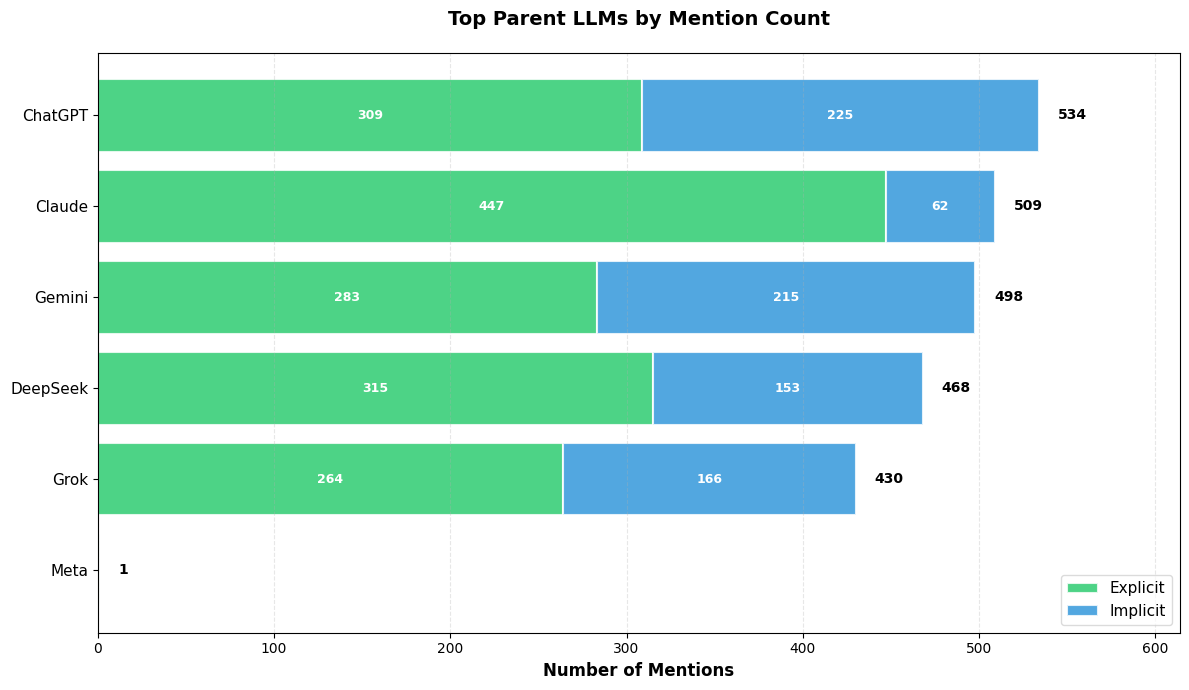


✓ Visualization created

 Parent LLM Mention Breakdown:

Rank   Parent LLM           Explicit     Implicit     Total      % of Total  
--------------------------------------------------------------------------------
1      ChatGPT              309          225          534          21.9%
2      Claude               447          62           509          20.9%
3      Gemini               283          215          498          20.4%
4      DeepSeek             315          153          468          19.2%
5      Grok                 264          166          430          17.6%
6      Meta                 1            0            1             0.0%

TOTAL                       1619         821          2440        100.0%

 Mention Source Summary:
   Total posts: 2440
   Explicit mentions: 1619 (66.4%)
   Implicit mentions: 821 (33.6%)
   Average mentions per post: 1.00


In [33]:
import matplotlib.pyplot as plt
print("="*70)
print("VISUALIZATION: TOP PARENT LLMs BY MENTION COUNT")
print("="*70)

# Count mentions by parent LLM and mention source
llm_mention_counts = entities_df.groupby(['llm_parent', 'mention_source']).size().unstack(fill_value=0)

# Calculate total mentions
llm_mention_counts['total'] = llm_mention_counts.sum(axis=1)

# Sort by total (all 6 parent LLMs)
llm_mention_counts = llm_mention_counts.sort_values('total', ascending=False)

print(f"\n Found {len(llm_mention_counts)} parent LLMs")

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Get data for plotting
llms = llm_mention_counts.index
explicit_counts = llm_mention_counts.get('explicit', 0)
implicit_counts = llm_mention_counts.get('implicit', 0)

# Create horizontal stacked bar chart
y_pos = range(len(llms))

ax.barh(y_pos, explicit_counts, label='Explicit', color='#2ecc71', alpha=0.85, edgecolor='white', linewidth=1.5)
ax.barh(y_pos, implicit_counts, left=explicit_counts, label='Implicit', color='#3498db', alpha=0.85, edgecolor='white', linewidth=1.5)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(llms, fontsize=11)
ax.invert_yaxis()  # Top to bottom
ax.set_xlabel('Number of Mentions', fontsize=12, fontweight='bold')
ax.set_title('Top Parent LLMs by Mention Count', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.7)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Set x-axis limits with some padding
max_mentions = llm_mention_counts['total'].max()
ax.set_xlim(0, max_mentions * 1.15)

# Add value labels on bars
for i, (llm, row) in enumerate(llm_mention_counts.iterrows()):
    explicit = row.get('explicit', 0)
    implicit = row.get('implicit', 0)
    total = row['total']
    
    # Add total at the end of the bar
    ax.text(total + (max_mentions * 0.02), i, f'{total:.0f}', 
            va='center', fontsize=10, fontweight='bold')
    
    # Add explicit count inside bar (if large enough)
    if explicit > max_mentions * 0.1:
        ax.text(explicit/2, i, f'{explicit:.0f}', 
                va='center', ha='center', fontsize=9, color='white', fontweight='bold')
    
    # Add implicit count inside bar (if large enough)
    if implicit > max_mentions * 0.1:
        ax.text(explicit + implicit/2, i, f'{implicit:.0f}', 
                va='center', ha='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization created")

# Print the data table
print("\n Parent LLM Mention Breakdown:")
print(f"\n{'Rank':<6} {'Parent LLM':<20} {'Explicit':<12} {'Implicit':<12} {'Total':<10} {'% of Total':<12}")
print("-" * 80)

total_all_mentions = llm_mention_counts['total'].sum()

for rank, (llm, row) in enumerate(llm_mention_counts.iterrows(), 1):
    explicit = row.get('explicit', 0)
    implicit = row.get('implicit', 0)
    total = row['total']
    pct = (total / total_all_mentions) * 100
    
    print(f"{rank:<6} {llm:<20} {explicit:<12.0f} {implicit:<12.0f} {total:<10.0f} {pct:>6.1f}%")

print(f"\n{'TOTAL':<6} {'':<20} {explicit_counts.sum():<12.0f} {implicit_counts.sum():<12.0f} {total_all_mentions:<10.0f} {'100.0%':>7s}")

# Additional statistics
print(f"\n Mention Source Summary:")
print(f"   Total posts: {len(entities_df)}")
print(f"   Explicit mentions: {explicit_counts.sum():.0f} ({explicit_counts.sum()/total_all_mentions*100:.1f}%)")
print(f"   Implicit mentions: {implicit_counts.sum():.0f} ({implicit_counts.sum()/total_all_mentions*100:.1f}%)")
print(f"   Average mentions per post: {total_all_mentions/len(entities_df):.2f}")
